In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import math

In [48]:
# Check if CUDA is enabled and Pytorch can use it
!nvidia-smi

Mon Jul 29 14:43:27 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P0             32W /  250W |    4693MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [26]:
torch.cuda.is_available()

True

In [27]:
# Hyperparams - not exhaustive, so need to add as we progress

NOISE_DIM = 512
LATENT_DIM = 512
BATCH_SIZE = 8
NUM_EPOCHS = 100
LEARNING_RATE = 0.000005
BETA1 = 0#0.5
BETA2 = 0.99#0.999
GAMMA = 10

# Model Architectures


In [28]:
# Mapping function F - working

class MappingFn(nn.Module):
    def __init__(self, z_dim, w_dim, n_layers=8):
        super(MappingFn, self).__init__()
        layers = nn.ModuleList()
        layers.append(nn.Linear(z_dim, w_dim))
        for _ in range(n_layers - 1):
            layers.append(nn.LeakyReLU(0.2))
            layers.append(nn.Linear(w_dim, w_dim))
        self.mapping = nn.Sequential(*layers)

    def forward(self, z):
        return self.mapping(z)

In [29]:
# Encoder E - working

# Encoder helper functions

# class FromRGB(nn.Module):
#     def __init__(self, out_channels):
#         super(FromRGB, self).__init__()
#         self.from_rgb = nn.Conv2d(3, out_channels, 1)
#     def forward(self, x):
#         x = self.from_rgb(x)
#         x = F.leaky_relu(x, 0.2)
#         return x

# class ToRGB(nn.Module):
#     def __init__(self, in_channels):
#         super(ToRGB, self).__init__()
#         self.to_rgb = nn.Conv2d(in_channels, 3, 1)

#     def forward(self, x):
#         x = self.to_rgb(x)
#         return x

# class Blur(nn.Module):
#     def __init__(self, channels):
#         super(Blur, self).__init__()
#         f = np.array([1, 2, 1], dtype=np.float32)
#         f = f[:, np.newaxis] * f[np.newaxis, :]
#         f /= np.sum(f)
#         kernel = torch.Tensor(f).view(1, 1, 3, 3).repeat(channels, 1, 1, 1)
#         self.register_buffer('weight', kernel)
#         self.groups = channels

#     def forward(self, x):
#         return F.conv2d(x, weight=self.weight, groups=self.groups, padding=1)

def upscale2d(x, factor=2):
    s = x.shape
    x = torch.reshape(x, [-1, s[1], s[2], 1, s[3], 1])
    x = x.repeat(1, 1, 1, factor, 1, factor)
    x = torch.reshape(x, [-1, s[1], s[2] * factor, s[3] * factor])
    return x

def pixel_norm(x, epsilon=1e-8):
    return x * torch.rsqrt(torch.mean(x.pow(2.0), dim=1, keepdim=True) + epsilon)

def style_mod(x, style):
    style = style.view(style.shape[0], 2, x.shape[1], 1, 1)
    return torch.addcmul(style[:, 1], value=1.0, tensor1=x, tensor2=style[:, 0] + 1)


# Encoder block

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, latent_size=LATENT_DIM, last=False, fused_scale=False):
        super(EncoderBlock, self).__init__()

#         self.blur = Blur(in_channels)
        self.last = last
        self.fused_scale = fused_scale

        self.conv_1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.bias_1 = nn.Parameter(torch.Tensor(1, in_channels, 1, 1))
        self.in_1 = nn.InstanceNorm2d(in_channels)

        if last:
            self.dense = nn.Linear(in_channels * 4 * 4, out_channels)
        else:
            self.conv_2 = nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False)

        # self.conv_2 = nn.Conv2d(in_channels, out_channels, 3, 2, 1, bias=False, transform_kernel=True)
        self.bias_2 = nn.Parameter(torch.Tensor(1, out_channels, 1, 1))
        self.in_2 = nn.InstanceNorm2d(out_channels)

        self.stylemap_1 = nn.Linear(2 * in_channels, latent_size)
        if last:
            self.stylemap_2 = nn.Linear(out_channels, latent_size)
        else:
            self.stylemap_2 = nn.Linear(2 * out_channels, latent_size)

        with torch.no_grad():
            self.bias_1.zero_()
            self.bias_2.zero_()

    def forward(self, x):
        # print("BLOCK")
        # print(f"{x.shape} -> conv3x3")
        x = self.conv_1(x) + self.bias_1
        x = F.leaky_relu(x, 0.2)
        # print(f"{x.shape} -> IN")

        mu_1 = torch.mean(x, dim=[2, 3], keepdim=True)
        sigma_1 = torch.std(x, dim=[2, 3], keepdim=True)
        style_1 = torch.cat((mu_1, sigma_1), dim=1)

        x = self.in_1(x)
        # print(f"IN -> {x.shape} ->")

        if self.last:
            x = self.dense(x.view(x.shape[0], -1))
            # print(f"Dense -> {x.shape}")

            x = F.leaky_relu(x, 0.2)
            s1 = self.stylemap_1(style_1.view(style_1.shape[0], style_1.shape[1]))
            s2 = self.stylemap_2(x.view(x.shape[0], x.shape[1]))
        else:
            # x = self.conv_2(self.blur(x))
            x = self.conv_2(x)
            # print(f"Conv3x3 -> {x.shape}")
            # if not self.fused_scale:
            x = F.avg_pool2d(x, 2, 2)
            # print(f"Avgpool -> {x.shape}")
            x = x + self.bias_2

            x = F.leaky_relu(x, 0.2)

            mu_2 = torch.mean(x, dim=[2, 3], keepdim=True)
            sigma_2 = torch.std(x, dim=[2, 3], keepdim=True)
            style_2 = torch.cat((mu_2, sigma_2), dim=1)

            x = self.in_2(x)
            # print(f"IN -> {x.shape} ->")

            # Styles extracted are linear maps of mu and sigma
            s1 = self.stylemap_1(style_1.view(style_1.shape[0], style_1.shape[1]))
            s2 = self.stylemap_2(style_2.view(style_2.shape[0], style_2.shape[1]))

            # print("\n")

        return x, s1, s2


# Encoder

class Encoder(nn.Module):
    def __init__(self, in_channels=64, latent_dim=LATENT_DIM):
        super(Encoder, self).__init__()
        self.latent_size = latent_dim
        self.in_channels = in_channels

        # Encoder blocks
        self.EncBlocks = nn.ModuleList([
            EncoderBlock(self.in_channels, 128),    # 256x256 -> 128x128
            EncoderBlock(128, 256),   # 128x128 -> 64x64
            EncoderBlock(256, 256),  # 64x64 -> 32x32
            EncoderBlock(256, 256),  # 32x32 -> 16x16
            EncoderBlock(256, 256),  # 16x16 -> 8x8
            EncoderBlock(256, 256),  # 8x8 -> 4x4
            EncoderBlock(256, 256, last=True),  # 4x4 -> 4x4
        ])

#         self.from_rgb = FromRGB(self.in_channels)
        self.from_gray = nn.Conv2d(1, self.in_channels, 1)


    def forward(self, x):
        # Vector to store latent code (w)
        w = torch.zeros(x.shape[0], 1, self.latent_size).to(x.device)

        # Convert from RGB to input channel dimension
#         x = self.from_rgb(x)
        x = self.from_gray(x)
        x = F.leaky_relu(x)

        # pass through 7 encoder blocks and extract 'styles'
        for block in self.EncBlocks:
            x, s1, s2 = block(x)
            w[:, 0] += s1 + s2   # latent codes = sum of styles

        # reshape w to size 512
        w = w.view(w.shape[0], -1)
#         print(f"w shape: {w.shape}")

        return w


## Test the Encoder

encoder = Encoder(32, LATENT_DIM)

# Noise image input
# noise_input = torch.randn(1, 3, 256, 256)
noise_input = torch.randn(1, 1, 256, 256)

# Real image input
from PIL import Image

# real_input = torch.tensor(np.array(Image.open('/kaggle/input/mri-image-single/Tr-no_0015.jpg'))).permute(2, 0, 1)
# real_input = real_input.float() / 255.0
# real_input = real_input.unsqueeze(0)

test_input = noise_input
# test_input = real_input

enc_output = encoder(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {enc_output.shape}")
# print("Latent code w:")
# print(enc_output)

Input shape: torch.Size([1, 1, 256, 256])
Output shape: torch.Size([1, 512])


In [30]:
# Decoder - Working

# Decoder helper functions

class InjectNoise(nn.Module):
    def __init__(self, channels):
        super(InjectNoise, self).__init__()
        self.weight = nn.Parameter(torch.zeros(1, channels, 1, 1))

    def forward(self, x, noise=None):
        if noise is None:
            noise = torch.randn(x.size(0), 1, x.size(2), x.size(3)).to(x.device)
        return x + self.weight * noise

class AdaIN(nn.Module):
    def __init__(self, channels, w_dim):
        super(AdaIN, self).__init__()
        self.fc = nn.Linear(w_dim, channels * 2)
        self.norm = nn.InstanceNorm2d(channels, affine=False)

    def forward(self, x, w):
        style = self.fc(w)
#         print(f"x shape: {x.shape}")
#         print(f"w shape: {w.shape}")
#         print(f"style shape: {style.shape}")
        # style = style.view(style.size(0), -1, 1, 1)
#         print(f"style shape: {style.shape}")
        # gamma, beta = style.chunk(2, 1)
        gamma, beta = style.tensor_split(2, 1)
#         print(f"gamma shape: {gamma.shape}")
#         print(f"beta shape: {beta.shape}")
        gamma = gamma.unsqueeze(2).unsqueeze(3)
        beta = beta.unsqueeze(2).unsqueeze(3)
#         print(f"gamma shape: {gamma.shape}")
#         print(f"beta shape: {beta.shape}")
#         print("\n")
        x = self.norm(x)
        return gamma * x + beta


# Decoder/Generator block - derived from StyleGAN architecture

class StyleDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, w_dim=LATENT_DIM, first=False):
        super(StyleDecoderBlock, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.inject_noise = InjectNoise(out_channels)
        self.adain = AdaIN(out_channels, w_dim)
        self.lrelu = nn.LeakyReLU(0.2)
        self.first = first

    def forward(self, x, w, noise=None):
        if not self.first: # Upsample -> Conv3x3 ->
            x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
            x = self.conv_1(x)

        # Inject noise -> AdaIN -> Conv3x3 -> Inject noise -> AdaIN
        x = self.inject_noise(x, noise)
        x = self.lrelu(x)
        x = self.adain(x, w)
        x = self.conv_2(x)
        x = self.inject_noise(x, noise)
        x = self.lrelu(x)
        x = self.adain(x, w)

        return x


# Decoder/Generator

class Generator(nn.Module):
    def __init__(self, z_dim=NOISE_DIM, w_dim=LATENT_DIM):
        super(Generator, self).__init__()
        self.init_const = nn.Parameter(torch.randn(1, 512, 4, 4))
        self.adain = AdaIN(512, w_dim)
        self.inject_noise = InjectNoise(512)
        self.lrelu = nn.LeakyReLU(0.2)

        # self.blocks = nn.ModuleList()
        # self.resolutions = [8, 16, 32, 64, 128, 256, 512]
        # self.channels = [512, 512, 512, 256, 128, 64]

        # in_channels = 512
        # for res, out_channels in zip(self.resolutions, self.channels):
        # for out_channels in self.channels:
            # self.blocks.append(StyleDecoderBlock(in_channels, out_channels, 3, w_dim))
            # self.blocks.append(StyleDecoderBlock(out_channels, out_channels, 3, w_dim))
            # in_channels = out_channels

        self.DecBlocks = nn.ModuleList([
            StyleDecoderBlock(512, 512, 3, first=True),  # 4x4 -> 4x4
            StyleDecoderBlock(512, 512, 3),              # 4x4 -> 8x8
            StyleDecoderBlock(512, 256, 3),              # 8x8 -> 16x16
            StyleDecoderBlock(256, 256, 3),              # 16x16 -> 32x32
            StyleDecoderBlock(256, 256, 3),              # 32x32 -> 64x64
            StyleDecoderBlock(256, 128, 3),              # 64x64 -> 128x128
            StyleDecoderBlock(128, 64, 3),               # 128x128 -> 256x256
        ])

        self.to_rgb = nn.Conv2d(64, 3, 1)
        self.to_gray = nn.Conv2d(64, 1, 1)

    def forward(self, w):
        # Const_4x4x512
        x = self.init_const.expand(w.size(0), -1, -1, -1)
        # print(f"const shape: {x.shape}")

        i=1
        for block in self.DecBlocks:
            x = block(x, w)
            # print(f"\n-> block{i} ->\n\nx shape: {x.shape}")
            i+=1

        # Convert decoder output to RGB and return
#         rgb = self.to_rgb(x)
        # print(f"\n-> to rgb ->\n\noutput shape: {rgb.shape}")
#         return rgb

        return self.to_gray(x)

## Test the ddeodcer

# Example usage
z_dim = 512
w_dim = 512
gen = Generator(z_dim, w_dim)
fmap = MappingFn(z_dim, w_dim)

# Generate a random latent vector
z = torch.randn(1, z_dim)

# Generate an image
# dec_output = gen(z)   # Using a random latent vector
# dec_output = gen(fmap(z))  # Using the latent vector from mapping function
# print(output[0].shape)
dec_output = gen(enc_output) # using latent vector from Encoder
print(dec_output.shape)  # Should print torch.Size([1, 3, 256, 256]) if rgb, [1, 1, 256, 256] if grayscale

torch.Size([1, 1, 256, 256])


(256, 256)


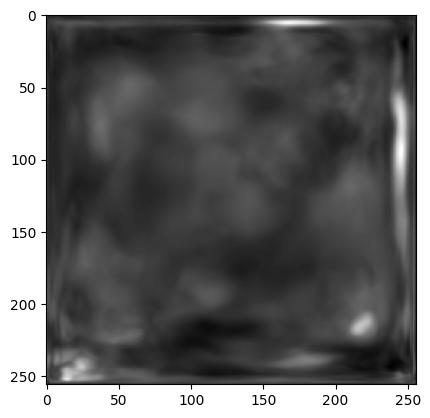

In [31]:
# visualise decoder output image
import matplotlib.pyplot as plt
out = dec_output.detach().squeeze().numpy()#.reshape(256, 256)
print(out.shape)
plt.imshow(out, cmap='gray')
plt.show()

In [32]:
# Latent Discriminator D (3-layer MLP) - working

class Discriminator(nn.Module):
    def __init__(self, input_dim=LATENT_DIM):
        super(Discriminator, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(input_dim, input_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(input_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.mlp(x)

# Test the Discriminator
Discrim = Discriminator()
discrim_output = Discrim(enc_output[0])
print(discrim_output)

tensor([0.4978], grad_fn=<SigmoidBackward0>)


# Data prep

In [33]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

### MRI Image preprocessing

Run only if your data is raw and needs to be preprocessed. Else skip to next section

In [34]:
# # Unzip raw mri image folder
# !unzip for_dlest.zip

In [35]:
# ### Run only if you want to preprocess the data and download it

# # Preprocess = 1) convert to 3-channel RGB + 2) resize to 256x256 + 3) zero-padding

# import zipfile

# def resize_and_save_images(input_folder, output_folder, target_size=(256, 256)):
#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder)

#     transform = transforms.Compose([
#         transforms.Resize(target_size),
#         transforms.Pad((0, 0, 0, 0), fill=0, padding_mode='constant'),  # No-op padding, can customize if needed
#     ])

#     for img_name in os.listdir(input_folder):
#         img_path = os.path.join(input_folder, img_name)
#         image = Image.open(img_path).convert("RGB")
#         image_resized = transform(image)
#         output_path = os.path.join(output_folder, img_name)
#         image_resized.save(output_path)

# def zip_folder(folder_path, zip_file_path):
#     with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
#         for root, dirs, files in os.walk(folder_path):
#             for file in files:
#                 file_path = os.path.join(root, file)
#                 zipf.write(file_path, os.path.relpath(file_path, folder_path))

# # Set the directories
# input_folder = 'for_dlest'
# # output_folder = 'for_dlest_resized'
# # zip_file_path = 'for_dlest_resized.zip'

# # Resize and save images
# resize_and_save_images(input_folder, output_folder)

# # Create a ZIP file
# zip_folder(output_folder, zip_file_path)

# print(f"Resized images saved in '{output_folder}' and zipped as '{zip_file_path}'")


### Load preprocessed data

Run if preprocessed data is already available in files directory

In [36]:
# # If data is in a ZIP folder, unzip it
# !unzip for_dlest_resized.zip

In [37]:
# Preprocess and load data into Dataloader

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = os.listdir(img_dir)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = Image.open(img_path)#.convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image

# Set the directory containing images
# img_dir = '/kaggle/input/mri-data-resized/for_dlest_resized'
img_dir = '/kaggle/input/ixi-t1-axial-unlabelled-256x256/IXI_axial_mri_T1_unlabeled_256x256'

# transform simply converts the preprocessed images into tensors
# If not preprocessed, optionally you can resize and pad the images
transform = transforms.Compose([
    # transforms.Resize((256, 256)),
    # transforms.Pad((0, 0, 0, 0), fill=0, padding_mode='constant'),  # No-op padding, can customize if needed
    transforms.ToTensor()
])

# Create the dataset
dataset = CustomImageDataset(img_dir=img_dir, transform=transform)

# # Create the DataLoader
# dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# Create the training set and testing set
train_size = int(0.96 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create the DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4, drop_last=True)

# Check shape of the batch
# for batch in dataloader:
for batch in train_loader:
    print(f"Batch size: {batch.size()}")  # should print [16, 3, 256, 256] assuming batch_size=16
#     print(batch[0][0][120][120].numpy())
    break


Batch size: torch.Size([8, 1, 256, 256])


154


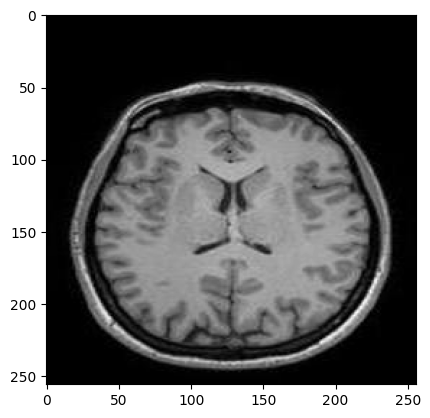

In [38]:
import PIL
image = PIL.Image.open(img_dir+"/IXI002-Guys-0828-T1.jpg")
np_image = np.array(image)
print(np_image[100][100])#.shape)
plt.imshow(image, cmap='gray')

# Training

In [39]:
!pip install pytorch-msssim
# Import SSIM
from pytorch_msssim import ssim

As per details provided in ALAE paper

In [40]:
# torch.cuda.empty_cache()

In [41]:
# # Model instances

# F_map = MappingFn(NOISE_DIM, LATENT_DIM).cuda()
# G = Generator().cuda()
# E = Encoder().cuda()
# D = Discriminator().cuda()

In [42]:
# # Optimizers

# optimizer_E_D = optim.Adam(list(E.parameters()) + list(D.parameters()), lr=LEARNING_RATE, betas=(BETA1, BETA2))
# optimizer_F_G = optim.Adam(list(F_map.parameters()) + list(G.parameters()), lr=LEARNING_RATE, betas=(BETA1, BETA2))
# optimizer_E_G = optim.Adam(list(E.parameters()) + list(G.parameters()), lr=LEARNING_RATE, betas=(BETA1, BETA2))

In [43]:
# # Training phase

# F_map.train()
# G.train()
# E.train()
# D.train()

# for epoch in range(NUM_EPOCHS):
#     for i, x in enumerate(train_loader):
#         x = x.cuda()  # Move data to GPU if available
#         x.requires_grad = True

#         ## Step I: Update E and D -- Discriminator's Adversarial Loss
#         optimizer_E_D.zero_grad()

#         z = torch.randn(BATCH_SIZE, NOISE_DIM).cuda()  # Sample from prior N(0, I)
#         F_z = F_map(z)
# #         print(f"F_z shape: {F_z.shape}")
#         G_F_z = G(F_z)
# #         print(f"G_F_z shape: {G_F_z.shape}")
#         E_G_F_z = E(G_F_z)
# #         print(f"E_G_F_z shape: {E_G_F_z.shape}")
# #         print(f"x shape: {x.shape}")
#         E_x = E(x)
# #         print(f"E_x shape: {E_x.shape}")
#         D_E_G_F_z = D(E_G_F_z)
# #         print(f"D_E_G_F_z shape: {D_E_G_F_z.shape}")
#         D_E_x = D(E_x)
# #         print(f"D_E_x shape: {D_E_x.shape}")
#         G_E_x = G(E_x)
# #         print(f"G_E_x shape: {G_E_x.shape}")

#         # Compute adversarial loss
# #         L_E_D_adv = F.softplus(D(E(G(F_map(z))))) + F.softplus(-D(E(x)))
#         L_E_D_adv = F.softplus(D_E_G_F_z) + F.softplus(-D_E_x)

#         # Gradient penalty term
#         # x.requires_grad = True
#         # D_x = D(E(x))
#         gradients = torch.autograd.grad(outputs=D_E_x, inputs=x, grad_outputs=torch.ones(D_E_x.size()).to(x.device), create_graph=True, retain_graph=True)[0]
#         gradients = gradients.view(BATCH_SIZE, -1)
#         gradient_penalty = GAMMA / 2.0 * torch.mean(gradients.norm(2, dim=1) ** 2)

#         # Total loss for E and D
#         L_E_D_total = L_E_D_adv + gradient_penalty
#         L_E_D_total.mean().backward()
#         optimizer_E_D.step()

        
#         ## Step II: Update F and G -- Generator's Adversarial Loss
#         optimizer_F_G.zero_grad()

#         z = torch.randn(BATCH_SIZE, NOISE_DIM).cuda()  # Sample from prior N(0, I)

#         # Compute adversarial loss
#         L_F_G_adv = F.softplus(-D(E(G(F_map(z)))))
# #         L_F_G_adv = F.softplus(-D_E_G_F_z)
#         L_F_G_adv.mean().backward()
#         optimizer_F_G.step()

#         ## Step III: Update E and G -- Latent Autoencoder Loss + Image Autoencoder Loss
#         optimizer_E_G.zero_grad()
        
# #         print(f"batch {i} done\n")

# #         z = torch.randn(BATCH_SIZE, NOISE_DIM).cuda()  # Sample from prior N(0, I)
# #         # Compute latent reconstruction loss
# #         L_G_E = F.mse_loss(F_map(z), E(G(F_map(z))))
# # #         L_G_E = F.mse_loss(F_z, E_G_F_z)
# #         L_G_E.mean().backward()
# #         optimizer_E_G.step()

# #         # Compute image reconstruction loss
# #         L_E_G = F.mse_loss(G(E(x)), x)
# #         L_E_G.mean().backward()
# #         optimizer_E_G.step()
        
# #         print(f"[Epoch {epoch}/{NUM_EPOCHS}] [Batch {i}/{len(dataloader)}]")

#         # Print losses for monitoring
# #         if i % 20 == 0:
#     print(f"[Epoch {epoch}/{NUM_EPOCHS}] [Batch {i}/{len(train_loader)}] [L_E_D_adv: {L_E_D_total.mean()}] [L_F_G_adv: {L_F_G_adv.mean()}]")# [L_E_G: {L_E_G.mean()}] [L_G_E: {L_G_E.mean()}]")


In [44]:
LAMBDA_REC = 15.0  # Weight for reconstruction loss
LAMBDA_SSIM = 5.0  # Weight for SSIM loss

In [45]:
from torch.optim.lr_scheduler import StepLR, ExponentialLR, ReduceLROnPlateau
G = Generator().cuda()
E = Encoder().cuda()

optimizer_E_G = optim.Adam(list(E.parameters()) + list(G.parameters()), lr=0.00001, betas=(0.5, 0.999))

scheduler_E_G = ReduceLROnPlateau(optimizer_E_G, mode='min', factor=0.5, patience=5, verbose=True)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# ONLY Autoencoder training - for image reconstruction

# 100 epochs, batch size 8

G.train()
E.train()

# def save_image(file, image):
#     Image.fromarray(image).save(file)
    
losses = {'E_G_mse': [], 'E_G_ssim': [], 'E_G_total': []}

losses_mse = []
losses_ssim = []

for epoch in range(1):
    epoch_losses = {k: 0.0 for k in losses.keys()}
    mse_epoch_losses = []
    ssim_epoch_losses = []
    for i, x in enumerate(train_loader):
        x = x.cuda()  # Move data to GPU if available
        x.requires_grad = True
        
        optimizer_E_G.zero_grad()
        x_rec = G(E(x))
        mse_loss = F.mse_loss(x_rec, x)
        ssim_loss = 1 - ssim(x_rec, x, data_range=1, size_average=True)  # SSIM loss
#         bce_loss = F.binary_cross_entropy(x_rec, x, reduction='sum')
        print(mse_loss)
        print(ssim_loss)
        print(bce_loss)
        L_E_G = LAMBDA_REC * mse_loss + LAMBDA_SSIM * ssim_loss# + bce_loss
#         L_E_G = ssim_loss  # experimental
        L_E_G.backward()
#         L_E_G.mean().backward()
        optimizer_E_G.step()
        
        epoch_losses['E_G_mse'] += mse_loss.item()
        epoch_losses['E_G_ssim'] += ssim_loss.item()
        epoch_losses['E_G_total'] += L_E_G.item()
        
        mse_epoch_losses.append(mse_loss.mean().detach().cpu())
        ssim_epoch_losses.append(ssim_loss.mean().detach().cpu())

        if i % 20 == 0:
            print(f"[Epoch {epoch}/{NUM_EPOCHS}] [Batch {i}/{len(train_loader)}] [L_E_G: {L_E_G.mean():.7f}] [mse: {mse_loss.mean():.7f}] [1-ssim: {ssim_loss.mean():.7f}]")
            
#     if epoch % 10 == 0:
#         save_image(f"images/ae/10July/epoch_{epoch+1}.png", G(E(x))[0].detach().cpu().numpy().reshape)
    # Calculate average losses for this epoch
    for k in epoch_losses:
        avg_loss = epoch_losses[k] / len(train_loader)
        losses[k].append(avg_loss)
#         print(f"Epoch {epoch} Average {k} Loss: {avg_loss:.4f}")
        
    losses_mse.append((np.mean(mse_epoch_losses), np.std(mse_epoch_losses)))
    losses_ssim.append((np.mean(ssim_epoch_losses), np.std(ssim_epoch_losses)))
    
    scheduler_E_G.step(losses['E_G_total'][-1])


# Testing

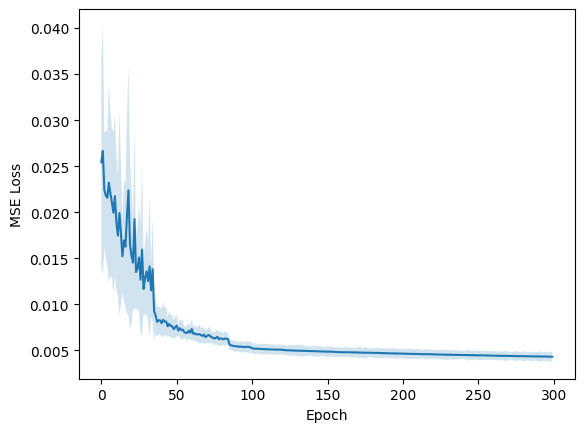

In [23]:
plt.plot([l[0] for l in losses_mse])
plt.fill_between(range(len(losses_mse)), [l[0] - l[1] for l in losses_mse], [l[0] + l[1] for l in losses_mse], alpha=0.2)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

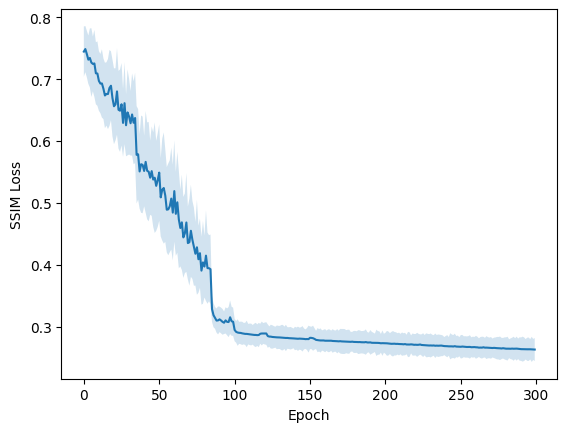

In [26]:
plt.plot([l[0] for l in losses_ssim])
plt.fill_between(range(len(losses_ssim)), [l[0] - l[1] for l in losses_ssim], [l[0] + l[1] for l in losses_ssim], alpha=0.2)
plt.xlabel("Epoch")
plt.ylabel("SSIM Loss")
plt.show()

In [25]:
np.save('gan_losses.npy', losses)

# Plot losses
plt.figure(figsize=(12, 8))
for k, v in losses.items():
    plt.plot(v, label=k)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Losses Over Time')
plt.legend()
plt.tight_layout()
plt.savefig('gan_losses.png')
plt.close()

In [ ]:
# def ssim_loss(x, y):
#     # Simplified SSIM loss
#     mu_x, mu_y = x.mean(), y.mean()
#     sigma_x, sigma_y = x.std(), y.std()
#     sigma_xy = ((x - mu_x) * (y - mu_y)).mean()
    
#     C1, C2 = 0.01**2, 0.03**2
#     ssim = (2*mu_x*mu_y + C1) * (2*sigma_xy + C2) / ((mu_x**2 + mu_y**2 + C1) * (sigma_x**2 + sigma_y**2 + C2))
#     return 1 - ssim.mean()



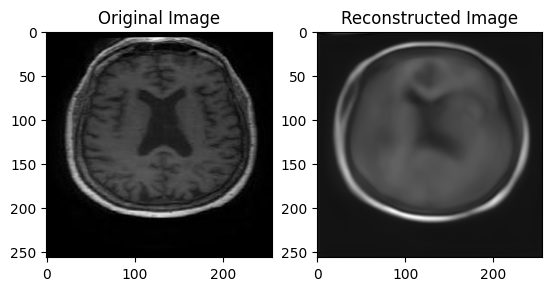

MSE: 0.014707336202263832
SSIM: 0.6327423453330994


In [43]:
# ONLY test the Autoencoder's reconstuction ability
# test_loader = dataloader
E.eval()
G.eval()

with torch.no_grad():
    for i, x in enumerate(test_loader):
        x = x.cuda()
        # Encode and then decode the image
        encoded = E(x)
        decoded = G(encoded)
        # Plot original and reconstructed images
        if i == 0:
            img_index = 0
            fig, axes = plt.subplots(1, 2)
            axes[0].imshow(x[img_index].permute(1, 2, 0).cpu().numpy(), cmap='gray')
            axes[0].set_title("Original Image")
            axes[1].imshow(decoded[img_index].permute(1, 2, 0).cpu().numpy(), cmap='gray')
            axes[1].set_title("Reconstructed Image")
            plt.show()
            print(f"MSE: {F.mse_loss(decoded[img_index], x[img_index])}")
            print(f"SSIM: {ssim(decoded[img_index].unsqueeze(1), x[img_index].unsqueeze(1), data_range=1, size_average=True)}")  # SSIM loss
        break

In [30]:
torch.save(E.state_dict(), '/kaggle/working/E_state_dict_ssim-26July.pth')
torch.save(G.state_dict(), '/kaggle/working/G_state_dict_ssim-26July.pth')

## * For Autoencoder training only run up till here *

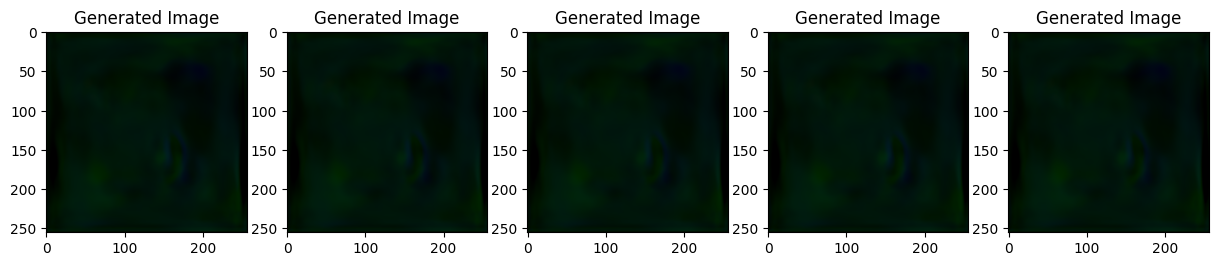

In [24]:
# Test the Generator's ability to synthesize realistic images

F_map.eval()
G.eval()
num_samples = 5

with torch.no_grad():
    z = torch.randn(num_samples, LATENT_DIM).cuda()
    generated_images = G(F_map(z))
    # Plot generated images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
    for i in range(num_samples):
        axes[i].imshow(generated_images[i].permute(1, 2, 0).cpu().numpy())
        axes[i].set_title("Generated Image")
    plt.show()


# Extra/rough code below

In [ ]:
### OLD CODE - IGNORE
# but do not delete

# Mapping Function F (8-layer MLP)
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        return self.layers(x)


# Defininf Convolution blocks for Decoder and Encoder
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 2, 1) if down
            else nn.ConvTranspose2d(in_channels, out_channels, 3, 2, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.conv(x)


# Stochastic Decoder G (with 8 decode blocks)
class Decoder(nn.Module):
    def __init__(self, channels=64):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(512, channels*7 * 2 * 2)
        self.blocks = nn.ModuleList([
            ConvBlock(channels*7, channels*6, down=False),
            ConvBlock(channels*6, channels*5, down=False),
            ConvBlock(channels*5, channels*4, down=False),
            ConvBlock(channels*4, channels*3, down=False),
            ConvBlock(channels*3, channels*2, down=False),
            ConvBlock(channels*2, channels, down=False),
            nn.ConvTranspose2d(channels, 1, 3, 2, 1, 1)
        ])

    def forward(self, x):
        x = self.fc(x).view(x.size(0), -1, 2, 2)
        for block in self.blocks[:-1]:
            x = block(x)
        return torch.tanh(self.blocks[-1](x))

# Encoder E (with 8 encode blocks)
class Encoder(nn.Module):
    def __init__(self, channels=64):
        super(Encoder, self).__init__()
        self.blocks = nn.ModuleList([
            ConvBlock(1, channels),
            ConvBlock(channels, channels*2),
            ConvBlock(channels*2, channels*3),
            ConvBlock(channels*3, channels*4),
            ConvBlock(channels*4, channels*5),
            ConvBlock(channels*5, channels*6),
            ConvBlock(channels*6, channels*7)
        ])
        self.fc = nn.Linear(channels*7 * 2 * 2, 512)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return self.fc(x.view(x.size(0), -1))



# Latent Discriminator D (3-layer MLP)
class Discriminator(nn.Module):
    def __init__(self, input_dim=LATENT_DIM):
        super(Discriminator, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(input_dim, input_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(input_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.mlp(x)




In [ ]:
## DOES NOT WORK - IGNORE
# but do not delete


# Decoder

class DecoderBlock(nn.Module):
    def __init__(self, inputs, outputs, latent_size=LATENT_DIM, has_first_conv=True, fused_scale=False, layer=0):
        super(DecoderBlock, self).__init__()
        self.has_first_conv = has_first_conv
        self.inputs = inputs
        self.has_first_conv = has_first_conv
        self.fused_scale = fused_scale
        if has_first_conv:
            if fused_scale:
                self.conv_1 = nn.ConvTranspose2d(inputs, outputs, 3, 2, 1, bias=False, transform_kernel=True)
            else:
                self.conv_1 = nn.Conv2d(inputs, outputs, 3, 1, 1, bias=False)

        self.blur = Blur(outputs)
        self.noise_weight_1 = nn.Parameter(torch.Tensor(1, outputs, 1, 1))
        self.noise_weight_1.data.zero_()
        self.bias_1 = nn.Parameter(torch.Tensor(1, outputs, 1, 1))
        self.in_1 = nn.InstanceNorm2d(outputs, affine=False, eps=1e-8)
        self.style_1 = nn.Linear(latent_size, 2 * outputs)

        self.conv_2 = nn.Conv2d(outputs, outputs, 3, 1, 1, bias=False)
        self.noise_weight_2 = nn.Parameter(torch.Tensor(1, outputs, 1, 1))
        self.noise_weight_2.data.zero_()
        self.bias_2 = nn.Parameter(torch.Tensor(1, outputs, 1, 1))
        self.in_2 = nn.InstanceNorm2d(outputs, affine=False, eps=1e-8)
        self.style_2 = nn.Linear(latent_size, 2 * outputs)

        self.layer = layer

        with torch.no_grad():
            self.bias_1.zero_()
            self.bias_2.zero_()

    def forward(self, x, s1, s2, noise):
        print("BLOCK")
        print(f"{x.shape} -> ")
        if self.has_first_conv:
            x = upscale2d(x)
            print(f"upscale -> {x.shape}")
            x = self.conv_1(x)
            print(f"conv_1 -> {x.shape}")
            x = self.blur(x)
            print(f"blur -> {x.shape}")

        if noise:
            if noise == 'batch_constant':
                x = torch.addcmul(x, value=1.0, tensor1=self.noise_weight_1,
                                  tensor2=torch.randn([1, 1, x.shape[2], x.shape[3]]))
            else:
                x = torch.addcmul(x, value=1.0, tensor1=self.noise_weight_1,
                                  tensor2=torch.randn([x.shape[0], 1, x.shape[2], x.shape[3]]))
            print(f"noise -> {x.shape}")

        else:
            s = math.pow(self.layer + 1, 0.5)
            x = x + s * torch.exp(-x * x / (2.0 * s * s)) / math.sqrt(2 * math.pi) * 0.8
        x = x + self.bias_1

        x = F.leaky_relu(x, 0.2)
        x = self.in_1(x)

        style = self.style_1(s1)
        print(f"style shape: {style.shape}")
        x = style_mod(x, style.view(style.shape[0], 2, x.shape[1], 1, 1))
        print(f"AdaIN_1 -> {x.shape}")
        x = self.conv_2(x)
        print(f"conv_2 -> {x.shape}")

        if noise:
            if noise == 'batch_constant':
                x = torch.addcmul(x, value=1.0, tensor1=self.noise_weight_2,
                                  tensor2=torch.randn([1, 1, x.shape[2], x.shape[3]]))
            else:
                x = torch.addcmul(x, value=1.0, tensor1=self.noise_weight_2,
                                  tensor2=torch.randn([x.shape[0], 1, x.shape[2], x.shape[3]]))
        else:
            s = math.pow(self.layer + 1, 0.5)
            x = x + s * torch.exp(-x * x / (2.0 * s * s)) / math.sqrt(2 * math.pi) * 0.8

        x = x + self.bias_2
        x = F.leaky_relu(x, 0.2)
        x = self.in_2(x)
        style_1 = self.style_2(s2)
        x = style_mod(x, style_1.view(style_1.shape[0], 2, x.shape[1], 1, 1))
        print(f"AdaIN_2 -> {x.shape}")
        print("\n")

        return x


class Decoder(nn.Module):
    def __init__(self, latent_size=LATENT_DIM, in_channels=256, out_channels=32):
        super(Decoder, self).__init__()
        # self.maxf = maxf
        # self.startf = startf
        # self.layer_count = layer_count
        self.latent_size = latent_size

        # mul = 2 ** (self.layer_count - 1)
        self.out_channels = out_channels

        self.const = nn.Parameter(torch.Tensor(1, in_channels, 4, 4))
        nn.init.ones_(self.const)

        # Decoder blocks
        self.DecBlocks = nn.ModuleList([
            DecoderBlock(256, 256, layer=0, has_first_conv=False),   # 4x4 -> 8x8
            DecoderBlock(256, 256, layer=1),   # 4x4 -> 8x8
            DecoderBlock(256, 256, layer=2),  # 8x8 -> 16x16
            DecoderBlock(256, 256, layer=3),  # 16x16 -> 32x32
            DecoderBlock(256, 128, layer=4),  # 32x32 -> 64x64
            DecoderBlock(128, 64, layer=5),  # 64x64 -> 128x128
            DecoderBlock(64, self.out_channels, layer=6),  # 128x128 -> 256x256
        ])

        # self.layer_to_resolution = [0 for _ in range(layer_count)]
        # resolution = 2

        # self.style_sizes = []

        # self.decode_block: nn.ModuleList[DecodeBlock] = nn.ModuleList()
        # for i in range(self.layer_count):
        #     out_channels = min(self.maxf, startf * mul)

        #     has_first_conv = i != 0
        #     fused_scale = resolution * 2 >= 128

        #     block = DecodeBlock(in_channels, out_channels, latent_size, has_first_conv, fused_scale=fused_scale, layer=i)

        #     resolution *= 2
        #     self.layer_to_resolution[i] = resolution

        #     self.style_sizes += [2 * (in_channels if has_first_conv else out_channels), 2 * out_channels]

        #     to_rgb.append(ToRGB(out_channels, channels))

        #     self.decode_block.append(block)
        #     in_channels = outputs
        #     mul //= 2

    def forward(self, styles, noise):
        x = self.const
        print(f"style: {styles.shape}")

        for i in range(len(self.DecBlocks)):
            print(f"s1: {styles[:, 2 * i + 0].shape}")
            print(f"s2: {styles[:, 2 * i + 1].shape}")
            print("\n")
            x = self.DecBlocks[i](x, styles[:, 2 * i + 0], styles[:, 2 * i + 1], noise)

        # Convert to RGB
        x = nn.Conv2d(self.out_channels, 3, 1)(x)
        return x


# Test the decoder on the encoder's output
decoder = Decoder()
test_input = torch.randn(1, LATENT_DIM)
output = decoder(test_input, noise=True)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {output.shape}")

In [ ]:
# Usage example
from torchvision import datasets, transforms

# Define your dataset and dataloader
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.ImageFolder(root='path/to/your/dataset', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

# Initialize the model
sig = SIG()

# Train the model
train_SIG(sig, dataloader, num_epochs=100)

In [ ]:
# SIG Module (z, F, G, E, D)
class SIG(nn.Module):
    def __init__(self, latent_dim=512, noise_dim=4096):
        super(SIG, self).__init__()
        self.latent_dim = latent_dim
        self.noise_dim = noise_dim
        self.F = MLP(noise_dim, latent_dim)
        self.G = Decoder()
        self.E = Encoder()
        self.D = Discriminator(latent_dim)

    def forward(self, z, x):
        W = self.F(z)
        x_fake = self.G(W)
        W_recon = self.E(x_fake)
        R = self.E(x)
        return W, x_fake, W_recon, R


class SIGLoss:
    def __init__(self, gamma_reg=10):
        self.gamma_reg = gamma_reg

    def adversarial_loss_ED(self, D_fake, D_real, real_grad):
        loss = F.softplus(D_fake).mean() + F.softplus(-D_real).mean()
        # R_reg: zero-centered gradient penalty
        R_reg = (real_grad.norm(2, dim=1) ** 2).mean() * (self.gamma_reg / 2)
        return loss + R_reg

        # R_reg = torch.sum(real_grads.pow(2.0), dim=[1, 2, 3])  * (self.gamma_reg / 2)
        # loss = loss + R_reg
        # return loss.mean()

    def adversarial_loss_FG(self, D_fake):
        return F.softplus(-D_fake).mean()

    def reconstruction_loss(self, x_real, x_recon):
        return F.l1_loss(x_recon, x_real)

    def autoencoder_loss(self, W, W_recon):
        return F.mse_loss(W_recon, W)
        # return torch.mean((recon_x - x)**2)

def train_SIG(model, dataloader, num_epochs, lr=0.0002, beta1=0.5, beta2=0.999):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Assuming F, G, E, D are already defined and initialized
    optimizer_E_D = optim.Adam(list(model.E.parameters()) + list(model.D.parameters()), lr=lr, betas=(beta1, beta2))
    optimizer_F_G = optim.Adam(list(model.F.parameters()) + list(model.G.parameters()), lr=lr, betas=(beta1, beta2))
    optimizer_E_G = optim.Adam(list(model.E.parameters()) + list(model.G.parameters()), lr=lr, betas=(beta1, beta2))


    # optimizer_EG = optim.Adam(list(model.E.parameters()) + list(model.G.parameters()), lr=lr, betas=(beta1, beta2))
    # optimizer_F = optim.Adam(model.F.parameters(), lr=lr, betas=(beta1, beta2))
    # optimizer_D = optim.Adam(model.D.parameters(), lr=lr, betas=(beta1, beta2))

    criterion = SIGLoss()

    for epoch in range(num_epochs):
        for batch_idx, real_imgs in enumerate(dataloader):
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)

            # Generate Gaussian noise z
            z = torch.randn(batch_size, model.noise_dim).to(device)

            # Forward pass -> F -> G -> E ->
            W, x_fake, W_recon, R = model(z, real_imgs)

            # Compute gradients for R_reg
            real_imgs.requires_grad_(True)
            D_real = model.D(R)
            real_grad = torch.autograd.grad(D_real.sum(), R, create_graph=True)[0]

            # Discriminator loss
            D_fake = model.D(W_recon.detach())
            loss_D = criterion.adversarial_loss_ED(D_fake, D_real, real_grad)

            # Update Discriminator (E+D)
            optimizer_E_D.zero_grad()
            loss_D.backward()
            optimizer_E_D.step()


            # Generator loss (F+G)
            D_fake = model.D(W_recon)
            loss_FG_adv = criterion.adversarial_loss_FG(D_fake)
            # loss_EG_adv = criterion.adversarial_loss_ED(D_fake, D_real, real_grad)
            loss_EG_recon = criterion.reconstruction_loss(real_imgs, model.G(R))
            loss_EG_ae = criterion.autoencoder_loss(W, W_recon)

            loss_EG = loss_EG_ae + loss_EG_recon # + loss_EG_adv
            loss_FG = loss_FG_adv

            # Update Generator (F+G)
            optimizer_F_G.zero_grad()
            loss_EG.backward(retain_graph=True)
            optimizer_F_G.step()

            # Update Generator (F)
            optimizer_F.zero_grad()
            loss_FG.backward()
            optimizer_F.step()

            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(dataloader)} "
                      f"Loss D: {loss_D.item():.4f}, Loss EG: {loss_EG.item():.4f}, Loss FG: {loss_FG.item():.4f}")

### StyleGAN based Generator